# Install required libraries

In [ ]:
!pip install google-play-scraper pandas numpy matplotlib seaborn

print("✅ Libraries berhasil diinstall!")

✅ Libraries berhasil diinstall!


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google_play_scraper import app, reviews, Sort
import time
import random
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style untuk plotting
plt.style.use('default')
sns.set_palette("husl")

from datetime import datetime
import pytz

print("✅ Libraries berhasil diimport!")
print("📱 Siap memulai proses scraping Google Play Store...")

✅ Libraries berhasil diimport!
📱 Siap memulai proses scraping Google Play Store...


# Define Helper Functions

In [ ]:
def scrape_app_reviews(app_id, num_reviews=1200, lang='id', country='id'):
    """
    Scraping reviews dari Google Play Store

    Args:
        app_id: ID aplikasi di Play Store
        num_reviews: jumlah review yang ingin diambil
        lang: bahasa ('id' untuk Indonesia)
        country: negara ('id' untuk Indonesia)
    """
    print(f"🔄 Scraping reviews untuk: {app_id}")
    print(f"🎯 Target: {num_reviews} reviews")

    all_reviews = []
    continuation_token = None

    try:
        while len(all_reviews) < num_reviews:
            remaining = num_reviews - len(all_reviews)
            batch_size = min(remaining, 200)  # Max 200 per request

            # Ambil reviews dengan sorting newest
            result, continuation_token = reviews(
                app_id,
                lang=lang,
                country=country,
                sort=Sort.NEWEST,
                count=batch_size,
                continuation_token=continuation_token
            )

            if not result:
                print("⚠️ Tidak ada review lagi yang bisa diambil")
                break

            all_reviews.extend(result)

            # Progress indicator
            progress = len(all_reviews) / num_reviews * 100
            print(f"📊 Progress: {progress:.1f}% ({len(all_reviews)}/{num_reviews})")

            # Delay untuk menghindari rate limiting
            delay = random.uniform(0.5, 1.5)
            time.sleep(delay)

            # Jika tidak ada continuation token, coba sorting lain
            if not continuation_token:
                print("🔄 Mencoba dengan sorting berbeda...")
                try:
                    result2, _ = reviews(
                        app_id,
                        lang=lang,
                        country=country,
                        sort=Sort.RATING,
                        count=min(remaining, 200)
                    )
                    if result2:
                        all_reviews.extend(result2)
                        print(f"✅ Tambahan {len(result2)} reviews dari sorting RATING")
                except Exception as e:
                    print(f"⚠️ Error pada sorting RATING: {e}")
                break

    except Exception as e:
        print(f"❌ Error saat scraping: {e}")
        print(f"✅ Berhasil mengumpulkan {len(all_reviews)} reviews sebelum error")

    print(f"🏁 Scraping selesai: {len(all_reviews)} reviews terkumpul")
    return all_reviews

print("✅ Function scrape_app_reviews() siap digunakan!")

✅ Function scrape_app_reviews() siap digunakan!


# Define Data Processing Function

In [ ]:
def process_reviews(raw_reviews, app_name, app_id):
    """
    Memproses raw reviews menjadi format yang siap untuk analisis

    Args:
        raw_reviews: list of raw review data
        app_name: nama aplikasi
        app_id: ID aplikasi
    """
    print(f"🔧 Memproses {len(raw_reviews)} raw reviews...")

    processed_data = []

    for review in raw_reviews:
        data = {
            'app_id': app_id,
            'app_name': app_name,
            'review_id': review.get('reviewId', ''),
            'user_name': review.get('userName', ''),
            'content': review.get('content', ''),
            'score': review.get('score', 0),
            'thumbs_up_count': review.get('thumbsUpCount', 0),
            'at': review.get('at', ''),
        }

        # Tentukan label sentiment berdasarkan score
        if data['score'] >= 4:
            data['sentiment'] = 'positif'
        elif data['score'] <= 2:
            data['sentiment'] = 'negatif'
        else:
            data['sentiment'] = 'netral'

        processed_data.append(data)

    print(f"✅ Berhasil memproses {len(processed_data)} reviews")
    return processed_data

print("✅ Function process_reviews() siap digunakan!")

✅ Function process_reviews() siap digunakan!


# Configure Apps to Scrape

In [ ]:
print("📋 KONFIGURASI APLIKASI UNTUK DI-SCRAPING")
print("="*50)

# Daftar aplikasi populer Indonesia
app_configs = [
    ('com.gojek.app', 'Gojek'),
    ('com.tokopedia.tkpd', 'Tokopedia'),
    ('com.shopee.id', 'Shopee'),
    ('com.mobile.legends', 'Mobile Legends'),
    ('com.tencent.ig', 'PUBG Mobile'),
    ('com.instagram.android', 'Instagram'),
    ('com.whatsapp', 'WhatsApp'),
    ('com.spotify.music', 'Spotify'),
    ('com.netflix.mediaclient', 'Netflix'),
    ('com.google.android.youtube', 'YouTube')
]

print("Daftar aplikasi yang akan di-scraping:")
for i, (app_id, name) in enumerate(app_configs, 1):
    print(f"{i:2d}. {name:<20} ({app_id})")

print(f"\nTotal aplikasi: {len(app_configs)}")

# Parameter scraping
TARGET_PER_APP = 2000  # Target reviews per aplikasi
TARGET_TOTAL = 20000   # Target total untuk nilai maksimal

print(f"🎯 Target per aplikasi: {TARGET_PER_APP:,} reviews")
print(f"🎯 Target total: {TARGET_TOTAL:,} reviews")
print(f"⏱️ Estimasi waktu: 30-45 menit")

print("✅ Konfigurasi siap!")


📋 KONFIGURASI APLIKASI UNTUK DI-SCRAPING
Daftar aplikasi yang akan di-scraping:
 1. Gojek                (com.gojek.app)
 2. Tokopedia            (com.tokopedia.tkpd)
 3. Shopee               (com.shopee.id)
 4. Mobile Legends       (com.mobile.legends)
 5. PUBG Mobile          (com.tencent.ig)
 6. Instagram            (com.instagram.android)
 7. WhatsApp             (com.whatsapp)
 8. Spotify              (com.spotify.music)
 9. Netflix              (com.netflix.mediaclient)
10. YouTube              (com.google.android.youtube)

Total aplikasi: 10
🎯 Target per aplikasi: 2,000 reviews
🎯 Target total: 20,000 reviews
⏱️ Estimasi waktu: 30-45 menit
✅ Konfigurasi siap!


# Start Scraping Process

In [ ]:
print("🚀 MEMULAI PROSES SCRAPING")
print("="*50)
print("⚠️  PENTING: Jangan tutup browser/tab ini selama proses scraping!")
print("⚠️  Proses ini akan memakan waktu 30-45 menit")
print("⚠️  Jika ada error, cell bisa dijalankan ulang\n")

# Inisialisasi
all_data = []
successful_apps = []
failed_apps = []

tz = pytz.timezone("Asia/Jakarta")
start_time = datetime.now(tz)

print(f"⏰ Mulai scraping pada: {start_time.strftime('%Y-%m-%d %H:%M:%S')}\n")

# Loop untuk setiap aplikasi
for i, (app_id, expected_name) in enumerate(app_configs, 1):
    print(f"\n{'='*60}")
    print(f"📱 [{i}/{len(app_configs)}] SCRAPING: {expected_name}")
    print(f"{'='*60}")

    try:
        # Verifikasi aplikasi ada
        print("🔍 Mengecek informasi aplikasi...")
        app_info = app(app_id, lang='id', country='id')
        actual_name = app_info.get('title', expected_name)
        rating = app_info.get('score', 'N/A')
        installs = app_info.get('realInstalls', app_info.get('installs', 'N/A'))

        print(f"✅ App ditemukan!")
        print(f"   📱 Nama: {actual_name}")
        print(f"   ⭐ Rating: {rating}")
        print(f"   📥 Installs: {installs}")

        # Mulai scraping
        print(f"\n🔄 Memulai scraping reviews...")
        raw_reviews = scrape_app_reviews(app_id, TARGET_PER_APP)

        if raw_reviews:
            # Process reviews
            processed_reviews = process_reviews(raw_reviews, actual_name, app_id)
            all_data.extend(processed_reviews)
            successful_apps.append(actual_name)

            print(f"✅ BERHASIL: {len(processed_reviews)} reviews dari {actual_name}")
            print(f"📊 Total terkumpul: {len(all_data)} reviews")

            # Cek distribusi sentiment untuk app ini
            app_df = pd.DataFrame(processed_reviews)
            sentiment_dist = app_df['sentiment'].value_counts()
            print(f"🎭 Sentiment: Positif={sentiment_dist.get('positif', 0)}, "
                  f"Negatif={sentiment_dist.get('negatif', 0)}, "
                  f"Netral={sentiment_dist.get('netral', 0)}")

        else:
            print(f"❌ GAGAL: Tidak dapat mengumpulkan reviews dari {expected_name}")
            failed_apps.append(expected_name)

    except Exception as e:
        print(f"❌ ERROR pada {expected_name}: {e}")
        failed_apps.append(f"{expected_name} (Error: {str(e)[:50]})")
        continue

    # Progress keseluruhan
    progress = len(all_data) / TARGET_TOTAL * 100
    print(f"\n📊 PROGRESS KESELURUHAN: {progress:.1f}% ({len(all_data):,}/{TARGET_TOTAL:,})")

    # Break jika sudah mencapai target
    if len(all_data) >= TARGET_TOTAL:
        print(f"\n🎉 TARGET TERCAPAI! Total: {len(all_data):,} reviews")
        break

    # Jeda antar aplikasi
    if i < len(app_configs):
        print(f"⏳ Jeda 3 detik sebelum app berikutnya...")
        time.sleep(3)

# Summary scraping
end_time = datetime.now(tz)
duration = end_time - start_time

print(f"\n{'='*60}")
print(f"🏁 SCRAPING SELESAI!")
print(f"{'='*60}")
print(f"⏰ Waktu mulai: {start_time.strftime('%H:%M:%S')}")
print(f"⏰ Waktu selesai: {end_time.strftime('%H:%M:%S')}")
print(f"⏱️ Durasi total: {duration}")
print(f"📊 Total data terkumpul: {len(all_data):,} reviews")
print(f"✅ Aplikasi berhasil: {len(successful_apps)}")
print(f"❌ Aplikasi gagal: {len(failed_apps)}")

if successful_apps:
    print(f"\n✅ APLIKASI BERHASIL:")
    for app in successful_apps:
        print(f"   • {app}")

if failed_apps:
    print(f"\n❌ APLIKASI GAGAL:")
    for app in failed_apps:
        print(f"   • {app}")

🚀 MEMULAI PROSES SCRAPING
⚠️  PENTING: Jangan tutup browser/tab ini selama proses scraping!
⚠️  Proses ini akan memakan waktu 30-45 menit
⚠️  Jika ada error, cell bisa dijalankan ulang

⏰ Mulai scraping pada: 2025-09-04 10:45:32


📱 [1/10] SCRAPING: Gojek
🔍 Mengecek informasi aplikasi...
✅ App ditemukan!
   📱 Nama: Gojek - Transportasi & Makanan
   ⭐ Rating: 4.686242
   📥 Installs: 170492152

🔄 Memulai scraping reviews...
🔄 Scraping reviews untuk: com.gojek.app
🎯 Target: 2000 reviews
📊 Progress: 10.0% (200/2000)
📊 Progress: 20.0% (400/2000)
📊 Progress: 30.0% (600/2000)
📊 Progress: 40.0% (800/2000)
📊 Progress: 50.0% (1000/2000)
📊 Progress: 60.0% (1200/2000)
📊 Progress: 70.0% (1400/2000)
📊 Progress: 80.0% (1600/2000)
📊 Progress: 90.0% (1800/2000)
📊 Progress: 100.0% (2000/2000)
🏁 Scraping selesai: 2000 reviews terkumpul
🔧 Memproses 2000 raw reviews...
✅ Berhasil memproses 2000 reviews
✅ BERHASIL: 2000 reviews dari Gojek - Transportasi & Makanan
📊 Total terkumpul: 2000 reviews
🎭 Sentiment:

# Data Cleaning & Processing

In [ ]:
if all_data:
    print("🔧 MEMPROSES DATA FINAL")
    print("="*40)

    # Buat DataFrame
    print("📊 Membuat DataFrame...")
    df_raw = pd.DataFrame(all_data)
    print(f"✅ DataFrame dibuat: {df_raw.shape}")

    # Data cleaning steps
    print(f"\n🧹 PEMBERSIHAN DATA:")
    print(f"1️⃣ Data awal: {len(df_raw):,} reviews")

    # Remove duplicates berdasarkan content
    df = df_raw.drop_duplicates(subset=['content'], keep='first')
    print(f"2️⃣ Setelah remove duplicates: {len(df):,} reviews ({len(df_raw) - len(df)} removed)")

    # Remove empty/invalid content
    df = df[df['content'].notna()]  # Remove NaN
    df = df[df['content'].str.strip() != '']  # Remove empty strings
    df = df[df['content'].str.len() >= 5]  # Minimal 5 karakter
    print(f"3️⃣ Setelah remove empty content: {len(df):,} reviews")

    # Remove reviews yang terlalu pendek (kurang informatif)
    df = df[df['content'].str.len() >= 10]  # Minimal 10 karakter
    print(f"4️⃣ Setelah remove short reviews: {len(df):,} reviews")

    # Reset index
    df = df.reset_index(drop=True)

    print(f"\n✅ FINAL DATASET: {len(df):,} reviews")

else:
    print("❌ Tidak ada data yang berhasil dikumpulkan!")
    df = pd.DataFrame()


🔧 MEMPROSES DATA FINAL
📊 Membuat DataFrame...
✅ DataFrame dibuat: (20000, 9)

🧹 PEMBERSIHAN DATA:
1️⃣ Data awal: 20,000 reviews
2️⃣ Setelah remove duplicates: 15,514 reviews (4486 removed)
3️⃣ Setelah remove empty content: 15,260 reviews
4️⃣ Setelah remove short reviews: 14,308 reviews

✅ FINAL DATASET: 14,308 reviews


# Dataset Analysis & Visualization

In [ ]:
if not df.empty:
    print("📊 ANALISIS DATASET")
    print("="*40)

    # Basic statistics
    print(f"📈 STATISTIK DASAR:")
    print(f"   • Total reviews: {len(df):,}")
    print(f"   • Total aplikasi: {df['app_name'].nunique()}")
    print(f"   • Unique users: {df['user_name'].nunique():,}")
    print(f"   • Range tanggal: {df['at'].min()} - {df['at'].max()}")

    # Distribusi sentiment
    print(f"\n🎭 DISTRIBUSI SENTIMENT:")
    sentiment_counts = df['sentiment'].value_counts()
    total = len(df)
    for sentiment, count in sentiment_counts.items():
        percentage = count / total * 100
        print(f"   • {sentiment.title()}: {count:,} ({percentage:.1f}%)")

    # Distribusi rating
    print(f"\n⭐ DISTRIBUSI RATING:")
    rating_counts = df['score'].value_counts().sort_index()
    for rating, count in rating_counts.items():
        percentage = count / total * 100
        stars = '⭐' * rating
        print(f"   • {rating} {stars}: {count:,} ({percentage:.1f}%)")

    # Top aplikasi
    print(f"\n📱 TOP 10 APLIKASI (Jumlah Reviews):")
    app_counts = df['app_name'].value_counts().head(10)
    for i, (app_name, count) in enumerate(app_counts.items(), 1):
        print(f"   {i:2d}. {app_name:<25}: {count:,} reviews")

    # Statistik panjang review
    review_lengths = df['content'].str.len()
    print(f"\n📝 STATISTIK PANJANG REVIEW:")
    print(f"   • Min: {review_lengths.min()} karakter")
    print(f"   • Max: {review_lengths.max()} karakter")
    print(f"   • Mean: {review_lengths.mean():.1f} karakter")
    print(f"   • Median: {review_lengths.median():.1f} karakter")

else:
    print("❌ Dataset kosong, tidak dapat melakukan analisis!")


📊 ANALISIS DATASET
📈 STATISTIK DASAR:
   • Total reviews: 14,308
   • Total aplikasi: 10
   • Unique users: 14,088
   • Range tanggal: 2025-04-17 08:51:16 - 2025-09-03 03:36:01

🎭 DISTRIBUSI SENTIMENT:
   • Positif: 7,390 (51.6%)
   • Negatif: 6,022 (42.1%)
   • Netral: 896 (6.3%)

⭐ DISTRIBUSI RATING:
   • 1 ⭐: 5,109 (35.7%)
   • 2 ⭐⭐: 913 (6.4%)
   • 3 ⭐⭐⭐: 896 (6.3%)
   • 4 ⭐⭐⭐⭐: 966 (6.8%)
   • 5 ⭐⭐⭐⭐⭐: 6,424 (44.9%)

📱 TOP 10 APLIKASI (Jumlah Reviews):
    1. PUBG MOBILE              : 1,624 reviews
    2. Netflix                  : 1,620 reviews
    3. Tokopedia 9.9 PLUS Festival: 1,572 reviews
    4. Mobile Legends: Bang Bang: 1,478 reviews
    5. Shopee Indonesia         : 1,445 reviews
    6. Spotify: Music dan Podcast: 1,407 reviews
    7. Gojek - Transportasi & Makanan: 1,398 reviews
    8. Instagram                : 1,332 reviews
    9. WhatsApp Messenger       : 1,317 reviews
   10. YouTube                  : 1,115 reviews

📝 STATISTIK PANJANG REVIEW:
   • Min: 10 karakter

# Data Visualization

📈 MEMBUAT VISUALISASI


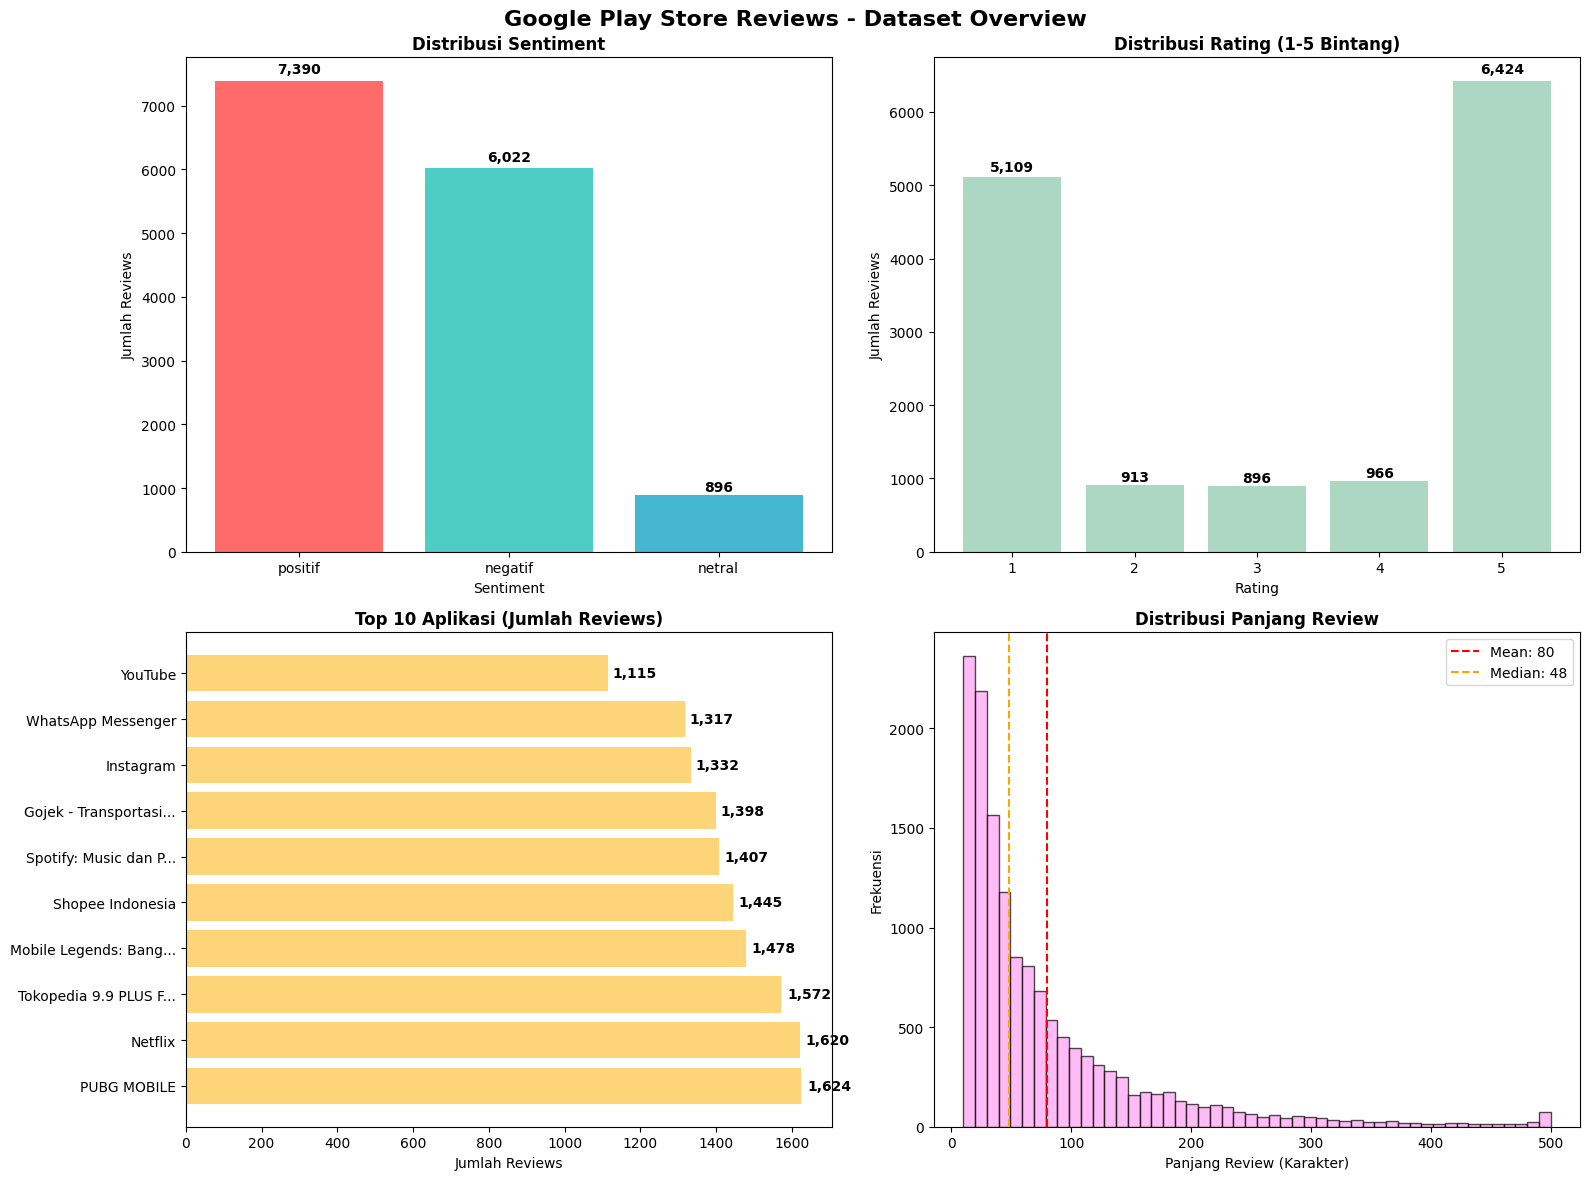

✅ Visualisasi berhasil dibuat!


In [ ]:
if not df.empty:
    print("📈 MEMBUAT VISUALISASI")
    print("="*30)

    # Setup plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Google Play Store Reviews - Dataset Overview',
                 fontsize=16, fontweight='bold', y=0.98)

    # 1. Sentiment Distribution
    sentiment_counts = df['sentiment'].value_counts()
    colors_sentiment = ['#ff6b6b', '#4ecdc4', '#45b7d1']

    bars1 = axes[0,0].bar(sentiment_counts.index, sentiment_counts.values,
                         color=colors_sentiment)
    axes[0,0].set_title('Distribusi Sentiment', fontweight='bold')
    axes[0,0].set_xlabel('Sentiment')
    axes[0,0].set_ylabel('Jumlah Reviews')

    # Add value labels on bars
    for bar, count in zip(bars1, sentiment_counts.values):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{count:,}', ha='center', va='bottom', fontweight='bold')

    # 2. Rating Distribution
    rating_counts = df['score'].value_counts().sort_index()
    bars2 = axes[0,1].bar(rating_counts.index, rating_counts.values,
                         color='#96ceb4', alpha=0.8)
    axes[0,1].set_title('Distribusi Rating (1-5 Bintang)', fontweight='bold')
    axes[0,1].set_xlabel('Rating')
    axes[0,1].set_ylabel('Jumlah Reviews')
    axes[0,1].set_xticks(range(1, 6))

    # Add value labels
    for bar, count in zip(bars2, rating_counts.values):
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'{count:,}', ha='center', va='bottom', fontweight='bold')

    # 3. Top 10 Apps
    app_counts = df['app_name'].value_counts().head(10)
    bars3 = axes[1,0].barh(range(len(app_counts)), app_counts.values,
                          color='#feca57', alpha=0.8)
    axes[1,0].set_title('Top 10 Aplikasi (Jumlah Reviews)', fontweight='bold')
    axes[1,0].set_xlabel('Jumlah Reviews')
    axes[1,0].set_yticks(range(len(app_counts)))
    axes[1,0].set_yticklabels([name[:20] + '...' if len(name) > 20 else name
                              for name in app_counts.index])

    # Add value labels
    for i, (bar, count) in enumerate(zip(bars3, app_counts.values)):
        width = bar.get_width()
        axes[1,0].text(width + width*0.01, bar.get_y() + bar.get_height()/2.,
                      f'{count:,}', ha='left', va='center', fontweight='bold')

    # 4. Review Length Distribution
    review_lengths = df['content'].str.len()
    axes[1,1].hist(review_lengths, bins=50, alpha=0.7, color='#ff9ff3', edgecolor='black')
    axes[1,1].set_title('Distribusi Panjang Review', fontweight='bold')
    axes[1,1].set_xlabel('Panjang Review (Karakter)')
    axes[1,1].set_ylabel('Frekuensi')
    axes[1,1].axvline(review_lengths.mean(), color='red', linestyle='--',
                     label=f'Mean: {review_lengths.mean():.0f}')
    axes[1,1].axvline(review_lengths.median(), color='orange', linestyle='--',
                     label=f'Median: {review_lengths.median():.0f}')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

    print("✅ Visualisasi berhasil dibuat!")

# Sample Data Preview

In [ ]:
if not df.empty:
    print("📄 PREVIEW SAMPLE DATA")
    print("="*40)

    # Ambil sample dari setiap sentiment
    sample_size = 2
    samples = []

    for sentiment in ['positif', 'negatif', 'netral']:
        sentiment_data = df[df['sentiment'] == sentiment].sample(
            min(sample_size, len(df[df['sentiment'] == sentiment])),
            random_state=42
        )
        samples.append(sentiment_data)

    sample_df = pd.concat(samples).reset_index(drop=True)

    print(f"Menampilkan {len(sample_df)} contoh review:\n")

    for idx, row in sample_df.iterrows():
        print(f"{'='*60}")
        print(f"📱 App: {row['app_name']}")
        print(f"⭐ Rating: {row['score']}/5")
        print(f"🎭 Sentiment: {row['sentiment'].upper()}")
        print(f"👤 User: {row['user_name']}")
        print(f"📅 Date: {row['at']}")
        print(f"📝 Review:")

        # Tampilkan review dengan word wrap
        content = row['content']
        if len(content) > 200:
            content = content[:200] + "..."
        print(f"   \"{content}\"")
        print()

📄 PREVIEW SAMPLE DATA
Menampilkan 6 contoh review:

📱 App: YouTube
⭐ Rating: 4/5
🎭 Sentiment: POSITIF
👤 User: hendra hendra
📅 Date: 2025-08-06 06:30:33
📝 Review:
   "tombol Play pause suka tidak muncul ketika di ketuk layar tengah"

📱 App: PUBG MOBILE
⭐ Rating: 5/5
🎭 Sentiment: POSITIF
👤 User: irfan kurniawan
📅 Date: 2025-08-15 03:05:41
📝 Review:
   "saya mau main tapi sayangnya hp saya ga kuat mainin nya 😓"

📱 App: Mobile Legends: Bang Bang
⭐ Rating: 1/5
🎭 Sentiment: NEGATIF
👤 User: Stututuu
📅 Date: 2025-09-02 14:39:45
📝 Review:
   "player solo di kasih tim kae babi Mulu"

📱 App: Tokopedia 9.9 PLUS Festival
⭐ Rating: 1/5
🎭 Sentiment: NEGATIF
👤 User: Nur Efendi
📅 Date: 2025-08-18 10:57:42
📝 Review:
   "Fitur pencarian error melulu, padahal biasanya nyari 12/256 langsung muncul hasil pencarian, tapi sekarang disuruh cari kata kunci lain.. Makin lama makin payah tokped"

📱 App: Netflix
⭐ Rating: 3/5
🎭 Sentiment: NETRAL
👤 User: Salsa Billa
📅 Date: 2025-07-20 03:38:28
📝 Review:
   "awalnya

# Save Dataset

In [ ]:
import os

if not df.empty:
    print("💾 MENYIMPAN DATASET")
    print("="*30)

    # Generate filename dengan timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'gps_reviews_dataset_{timestamp}.csv'

    # Simpan ke CSV
    print(f"📝 Menyimpan dataset ke: {filename}")
    df.to_csv(filename, index=False, encoding='utf-8')

    # Verifikasi file tersimpan
    if os.path.exists(filename):
        file_size = os.path.getsize(filename) / (1024*1024)  # MB
        print(f"✅ File berhasil disimpan!")
        print(f"   📄 Nama file: {filename}")
        print(f"   📊 Ukuran file: {file_size:.2f} MB")
        print(f"   📈 Jumlah baris: {len(df):,}")
        print(f"   📋 Jumlah kolom: {len(df.columns)}")
    else:
        print("❌ Error: File tidak berhasil disimpan!")

💾 MENYIMPAN DATASET
📝 Menyimpan dataset ke: gps_reviews_dataset_20250904_034801.csv
✅ File berhasil disimpan!
   📄 Nama file: gps_reviews_dataset_20250904_034801.csv
   📊 Ukuran file: 2.77 MB
   📈 Jumlah baris: 14,308
   📋 Jumlah kolom: 9


# Final Validation

In [ ]:
if not df.empty:
    print("✅ VALIDASI KRITERIA SUBMISSION DICODING")
    print("="*50)

    # Cek semua kriteria
    criteria_results = {}

    # Kriteria 1: Data hasil scraping mandiri
    criteria_results['scraping_mandiri'] = True
    print(f"1️⃣ Data hasil scraping mandiri: ✅ YA")

    # Kriteria minimal: ≥ 3,000 samples
    min_samples = len(df) >= 3000
    criteria_results['min_samples'] = min_samples
    print(f"2️⃣ Jumlah sampel ≥ 3,000: {len(df):,} ≥ 3,000 = {'✅ YA' if min_samples else '❌ TIDAK'}")

    # Kriteria optimal: ≥ 10,000 samples
    optimal_samples = len(df) >= 10000
    criteria_results['optimal_samples'] = optimal_samples
    print(f"3️⃣ Jumlah sampel ≥ 10,000 (optimal): {len(df):,} ≥ 10,000 = {'✅ YA' if optimal_samples else '❌ TIDAK'}")

    # Kriteria: 3 kelas sentiment
    three_classes = df['sentiment'].nunique() >= 3
    criteria_results['three_classes'] = three_classes
    print(f"4️⃣ Dataset memiliki ≥ 3 kelas: {df['sentiment'].nunique()} kelas = {'✅ YA' if three_classes else '❌ TIDAK'}")

    # Distribusi kelas seimbang (bonus)
    sentiment_dist = df['sentiment'].value_counts()
    min_class_pct = (sentiment_dist.min() / len(df)) * 100
    balanced_classes = min_class_pct >= 15  # Minimal 15% per kelas
    criteria_results['balanced_classes'] = balanced_classes
    print(f"5️⃣ Distribusi kelas seimbang (>15% per kelas): {min_class_pct:.1f}% = {'✅ YA' if balanced_classes else '⚠️ PERLU DIPERHATIKAN'}")

    print(f"\n📊 DISTRIBUSI AKHIR:")
    for sentiment, count in sentiment_dist.items():
        pct = (count / len(df)) * 100
        print(f"   • {sentiment.title()}: {count:,} ({pct:.1f}%)")

    # Overall assessment
    print(f"\n🏆 KESIMPULAN:")
    if optimal_samples and three_classes:
        print(f"🎉 EXCELLENT! Dataset memenuhi SEMUA kriteria untuk nilai maksimal!")
        print(f"   • Siap untuk model deep learning")
        print(f"   • Target 3 skema pelatihan dengan akurasi >92%")
    elif min_samples and three_classes:
        print(f"✅ BAGUS! Dataset memenuhi kriteria minimal untuk LULUS submission!")
        print(f"   • Siap untuk model machine learning")
        print(f"   • Target 3 skema pelatihan dengan akurasi >85%")
    else:
        print(f"⚠️ PERLU PERBAIKAN! Dataset belum memenuhi kriteria minimal.")
        if not min_samples:
            print(f"   • Perlu tambah data (minimal 3,000 samples)")
        if not three_classes:
            print(f"   • Perlu pastikan ada 3 kelas sentiment")

    # Next steps
    print(f"\n🚀 LANGKAH SELANJUTNYA:")
    print(f"   1. ✅ Data scraping selesai")
    print(f"   2. ⏭️  Data preprocessing & feature extraction")
    print(f"   3. ⏭️  Model training (3 skema berbeda)")
    print(f"   4. ⏭️  Model evaluation & inference")
    print(f"   5. ⏭️  Persiapan file submission")

else:
    print("❌ GAGAL! Tidak ada data yang berhasil dikumpulkan.")
    print("💡 Saran:")
    print("   • Coba jalankan ulang scraping")
    print("   • Periksa koneksi internet")
    print("   • Coba aplikasi yang berbeda")

print(f"\n🏁 SCRAPING PHASE COMPLETED!")
print(f"📝 File yang dihasilkan:")
if not df.empty:
    print(f"   • Dataset CSV: {filename}")
    print(f"   • Notebook: 01_Data_Scraping.ipynb")
print(f"   • Script: scraping_gps_reviews.py (akan dibuat terpisah)")

✅ VALIDASI KRITERIA SUBMISSION DICODING
1️⃣ Data hasil scraping mandiri: ✅ YA
2️⃣ Jumlah sampel ≥ 3,000: 14,308 ≥ 3,000 = ✅ YA
3️⃣ Jumlah sampel ≥ 10,000 (optimal): 14,308 ≥ 10,000 = ✅ YA
4️⃣ Dataset memiliki ≥ 3 kelas: 3 kelas = ✅ YA
5️⃣ Distribusi kelas seimbang (>15% per kelas): 6.3% = ⚠️ PERLU DIPERHATIKAN

📊 DISTRIBUSI AKHIR:
   • Positif: 7,390 (51.6%)
   • Negatif: 6,022 (42.1%)
   • Netral: 896 (6.3%)

🏆 KESIMPULAN:
🎉 EXCELLENT! Dataset memenuhi SEMUA kriteria untuk nilai maksimal!
   • Siap untuk model deep learning
   • Target 3 skema pelatihan dengan akurasi >92%

🚀 LANGKAH SELANJUTNYA:
   1. ✅ Data scraping selesai
   2. ⏭️  Data preprocessing & feature extraction
   3. ⏭️  Model training (3 skema berbeda)
   4. ⏭️  Model evaluation & inference
   5. ⏭️  Persiapan file submission

🏁 SCRAPING PHASE COMPLETED!
📝 File yang dihasilkan:
   • Dataset CSV: gps_reviews_dataset_20250904_034801.csv
   • Notebook: 01_Data_Scraping.ipynb
   • Script: scraping_gps_reviews.py (akan dibua